# 03 - Centroid Detection
## Übersicht
Nachdem die Puzzelteile gefunden sind, müssen wir den Geometrischer Schwerpunkt der einzelnen Teile herausfinden.

**Varianten:**
1. Contour Moment (geometrischer Schwerpunkt)
2. M3-Schraube (zuverlässigster Punkt)

### Installation von packages

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys

image_path = '../data/image-003.png'

### 1. Contour Moment
Hier wird basierend aus einer Mathematischen Formel versucht den Geometirschen formel zu finden.

### Schwerpunkt (Centroid) eines 2D-Polygons

Gegeben ist ein einfaches (nicht selbstschneidendes) Polygon mit den Punkten  
\((x_0, y_0), (x_1, y_1), (x_{n-1}, y_{n-1})\).  

Der letzte Punkt verbindet wieder zurück zum ersten: \(x_n = x_0,\; y_n = y_0\).

#### 1. Berechnung der signierten Fläche \(A\)

Die Fläche des Polygons (Vorzeichen abhängig von der Punktreihenfolge):

$$
A = \frac{1}{2} \sum_{i=0}^{n-1} 
\left( x_i\, y_{i+1} - x_{i+1}\, y_i \right)
$$

#### 2. Berechnung des Schwerpunktkoordinate \(C_x, C_y)

Die Schwerpunktkoordinaten erhält man durch:

$$
C_x = \frac{1}{6A} 
\sum_{i=0}^{n-1} (x_i + x_{i+1})
\left( x_i\, y_{i+1} - x_{i+1}\, y_i \right)
$$

$$
C_y = \frac{1}{6A} 
\sum_{i=0}^{n-1} (y_i + y_{i+1})
\left( x_i\, y_{i+1} - x_{i+1}\, y_i \right)
$$


Nachdem die Formel definiert wurde, hat man ein Methode erstellt welches dies umsetzt.

In [54]:
from dataclasses import dataclass
from typing import List

@dataclass
class Vector2:
    x: float
    y: float

def compute_polygon_centroid(points: List[Vector2]) -> Vector2:
    area = 0.0
    cx = 0.0
    cy = 0.0
    n = len(points)

    for i in range(n):
        current = points[i]
        next_point = points[(i + 1) % n]  # wrap around
        cross = current.x * next_point.y - next_point.x * current.y
        area += cross
        cx += (current.x + next_point.x) * cross
        cy += (current.y + next_point.y) * cross

    area *= 0.5
    cx /= (6 * area)
    cy /= (6 * area)

    return Vector2(cx, cy)

#### Beispielanwedung 2D-Polygons

In [55]:
polygon = [Vector2(0,0), Vector2(4,0), Vector2(4,3), Vector2(0,3)]
centroid = compute_polygon_centroid(polygon)
print(centroid)  # Vector2(x=2.0, y=1.5)

Vector2(x=2.0, y=1.5)


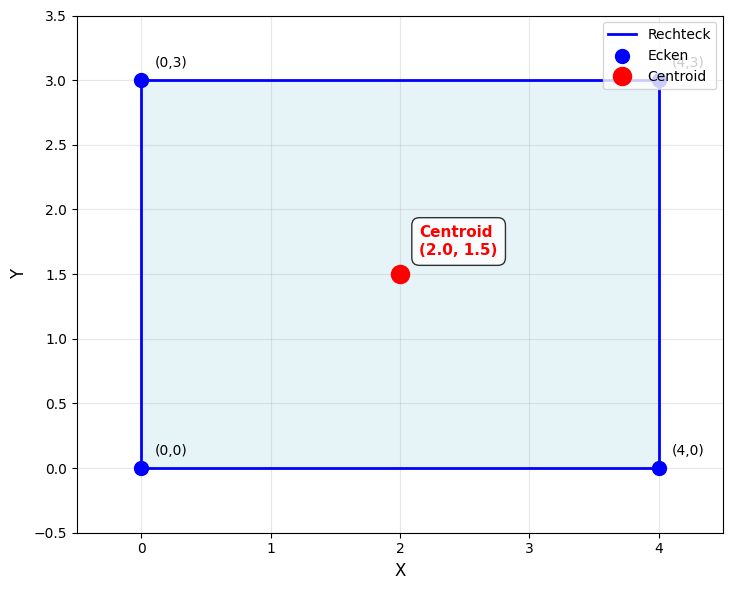

In [56]:
# Visualisierung des Rechtecks mit Centroid
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Polygon-Punkte extrahieren
polygon_points = np.array([[p.x, p.y] for p in polygon])

# Rechteck zeichnen (geschlossen)
polygon_closed = np.vstack([polygon_points, polygon_points[0]])  # Letzten Punkt wieder hinzufügen
ax.plot(polygon_closed[:, 0], polygon_closed[:, 1], 'b-', linewidth=2, label='Rechteck')
ax.fill(polygon_points[:, 0], polygon_points[:, 1], alpha=0.3, color='lightblue')

# Ecken des Rechtecks markieren
ax.scatter(polygon_points[:, 0], polygon_points[:, 1], c='blue', s=100, zorder=5, label='Ecken')
for i, point in enumerate(polygon_points):
    ax.text(point[0] + 0.1, point[1] + 0.1, f'({point[0]},{point[1]})', fontsize=10)

# Centroid markieren
ax.plot(centroid.x, centroid.y, 'ro', markersize=12, markeredgecolor='red', markeredgewidth=2, label='Centroid')
ax.text(centroid.x + 0.15, centroid.y + 0.15, f'Centroid\n({centroid.x:.1f}, {centroid.y:.1f})', 
        fontsize=11, color='red', weight='bold', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Achsen beschriften
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.set_aspect('equal')
ax.set_xlim(-0.5, 4.5)
ax.set_ylim(-0.5, 3.5)

plt.tight_layout()
plt.show()

#### Beispielanwedung reales Puzzelteiles

Nun wenden wir die Centroid-Berechnung auf ein reales Puzzleteil an. Wir verwenden die Solver-Pipeline, um Puzzelteile aus einem Bild zu extrahieren und deren Schwerpunkte zu berechnen.

In [63]:
# Klassen und Methoden aus dem Solver
class ImageLoader:
    @staticmethod
    def from_path(path):
        image = cv2.imread(path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {path}")
        return ImageLoader.__clean(image)
    
    @staticmethod
    def __clean(image):
        grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(grayscale, (5, 5), 0)
        _, threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return threshold

class ShapeDetector:
    @staticmethod
    def detect(image):
        gradient_x = cv2.Sobel(image, cv2.CV_16S, 1, 0)
        gradient_y = cv2.Sobel(image, cv2.CV_16S, 0, 1)
        gradient_x_abs = np.abs(gradient_x)
        gradient_y_abs = np.abs(gradient_y)
        return np.minimum(gradient_x_abs + gradient_y_abs, 255).astype(np.uint8)

FRAME_WIDTH_PERCENTAGE = 30

def detect_pieces(image):
    """Code aus PieceDetector.detect - extrahiert Puzzelteile und berechnet Centroiden"""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # define boundary for frame
    left_boundary = int(image.shape[1] * FRAME_WIDTH_PERCENTAGE / 100)
    
    pieces_data = []
    
    for contour in contours:
        # convert contour to Nx2 array
        coordinates = contour.reshape(-1, 2)
        
        # skip frame
        if np.any(coordinates[:, 0] < left_boundary):
            continue  # frame überspringen
        
        # piece
        points = [Vector2(x=float(pt[0]), y=float(pt[1])) for pt in coordinates]
        
        # Centroid berechnen (wie PolygonUtility.calculate_center_of_mass)
        if len(points) >= 3:
            centroid = compute_polygon_centroid(points)
            pieces_data.append({
                'points': points,
                'centroid': centroid
            })
    
    return pieces_data

# Bild laden (wie im Solver)
original_image = cv2.imread(image_path)

# ImageLoader verwendet (wie im Solver)
threshold_image = ImageLoader.from_path(image_path)

# ShapeDetector verwendet (wie im Solver)
processed_image = ShapeDetector.detect(threshold_image)

# Puzzelteile extrahieren
pieces_data = detect_pieces(processed_image)

print(f"Anzahl gefundener Puzzelteile: {len(pieces_data)}")
for i, piece_data in enumerate(pieces_data):
    print(f"  Teil {i+1}: Centroid = ({piece_data['centroid'].x:.2f}, {piece_data['centroid'].y:.2f}), Punkte = {len(piece_data['points'])}")

Anzahl gefundener Puzzelteile: 2
  Teil 1: Centroid = (636.36, 660.03), Punkte = 1150
  Teil 2: Centroid = (760.90, 233.45), Punkte = 995


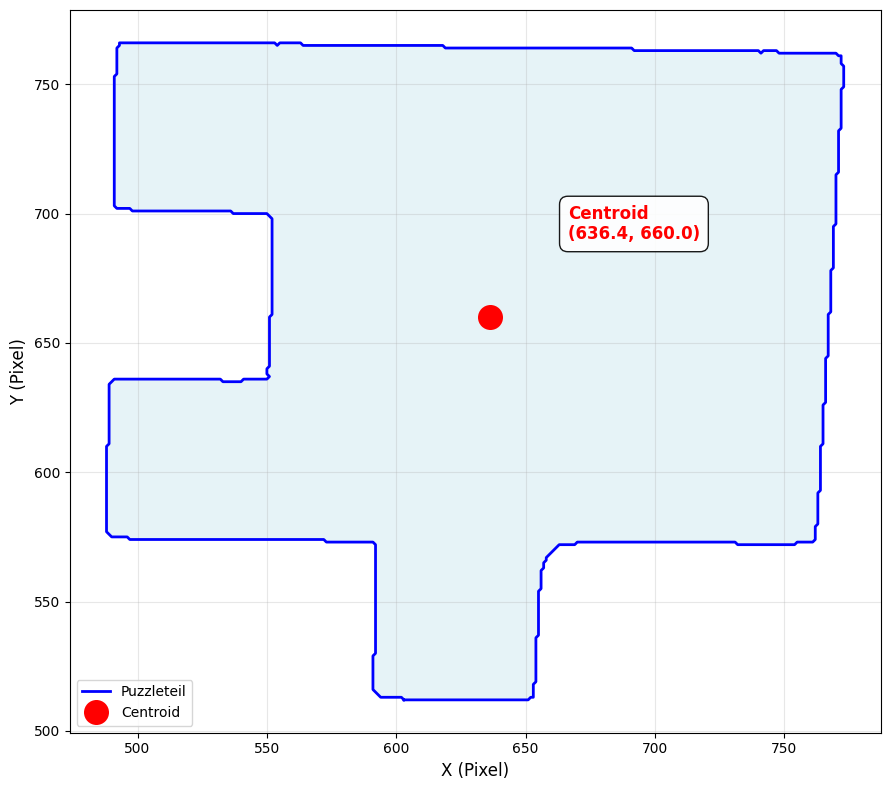

In [64]:
# Visualisierung eines einzelnen Puzzelteils mit Centroid
if len(pieces_data) > 0:
    # Erstes Puzzleteil auswählen
    selected_piece = pieces_data[0]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Polygon-Punkte extrahieren
    piece_points = np.array([[p.x, p.y] for p in selected_piece['points']])
    
    # Puzzleteil zeichnen (geschlossen)
    piece_closed = np.vstack([piece_points, piece_points[0]])  # Letzten Punkt wieder hinzufügen
    ax.plot(piece_closed[:, 0], piece_closed[:, 1], 'b-', linewidth=2, label='Puzzleteil')
    ax.fill(piece_points[:, 0], piece_points[:, 1], alpha=0.3, color='lightblue')
    
    # Centroid markieren
    centroid = selected_piece['centroid']
    ax.plot(centroid.x, centroid.y, 
            'ro', markersize=15, markeredgecolor='red', markeredgewidth=3, label='Centroid')
    ax.text(centroid.x + 30, centroid.y + 30, 
            f'Centroid\n({centroid.x:.1f}, {centroid.y:.1f})', 
            fontsize=12, color='red', weight='bold', 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))
    
    # Achsen beschriften
    ax.set_xlabel('X (Pixel)', fontsize=12)
    ax.set_ylabel('Y (Pixel)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

### 2. M3-Schraube
Als zweiter Variante wird veruscht M3-Schraube/Stift als Referenzpunkt zu verwenden.

In [65]:
def detect_m3_screw(piece_image, piece_mask=None):
    if len(piece_image.shape) == 3:
        gray = cv2.cvtColor(piece_image, cv2.COLOR_BGR2GRAY)
    else:
        gray = piece_image
    
    # HoughCircles: Suche nach kreisförmigen Features
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT,
        dp=1, minDist=30,
        param1=50, param2=30,
        minRadius=2, maxRadius=10
    )
    
    if circles is not None and len(circles[0]) > 0:
        x, y, r = circles[0][0]
        return (int(x), int(y))
    
    return None

# Bild laden (wie im Solver)
original_image = cv2.imread(image_path)

# ImageLoader verwendet (wie im Solver)
threshold_image = ImageLoader.from_path(image_path)

# ShapeDetector verwendet (wie im Solver)
processed_image = ShapeDetector.detect(threshold_image)

# Puzzelteile extrahieren
pieces_data = detect_pieces(processed_image)


# M3-Schraube für jedes Puzzleteil erkennen
# Für jedes Puzzelteil ein ROI (Region of Interest) extrahieren
m3_screw_positions = []
for i, piece_data in enumerate(pieces_data):
    # Bounding Box des Puzzelteils berechnen
    points = piece_data['points']
    x_coords = [p.x for p in points]
    y_coords = [p.y for p in points]
    
    min_x = int(max(0, min(x_coords) - 20))
    max_x = int(min(original_image.shape[1], max(x_coords) + 20))
    min_y = int(max(0, min(y_coords) - 20))
    max_y = int(min(original_image.shape[0], max(y_coords) + 20))
    
    # ROI extrahieren
    roi = original_image[min_y:max_y, min_x:max_x]
    
    # M3-Schraube im ROI suchen
    screw_pos = detect_m3_screw(roi)
    
    if screw_pos:
        # Position relativ zum Originalbild anpassen
        global_x = min_x + screw_pos[0]
        global_y = min_y + screw_pos[1]
        m3_screw_positions.append({
            'piece_index': i,
            'position': (global_x, global_y)
        })
        print(f"Puzzleteil {i+1}: M3-Schraube gefunden bei ({global_x:.1f}, {global_y:.1f})")
    else:
        m3_screw_positions.append({
            'piece_index': i,
            'position': None
        })
        print(f"Puzzleteil {i+1}: Keine M3-Schraube gefunden")

print(f"\nZusammenfassung: {sum(1 for p in m3_screw_positions if p['position'] is not None)} von {len(pieces_data)} Puzzelteilen haben eine M3-Schraube")

Puzzleteil 1: Keine M3-Schraube gefunden
Puzzleteil 2: Keine M3-Schraube gefunden

Zusammenfassung: 0 von 2 Puzzelteilen haben eine M3-Schraube


### Zusammenfassung
Beim Versuch, den Schwerpunkt mithilfe der M3-Schraube zu bestimmen, hat sich gezeigt, dass das Ergebnis stark von der Bildqualität und der Bildverarbeitung abhängt. Aufgrund dieses Risikos wurde entschieden, vorerst weiterhin die geometrische Formel zu verwenden.


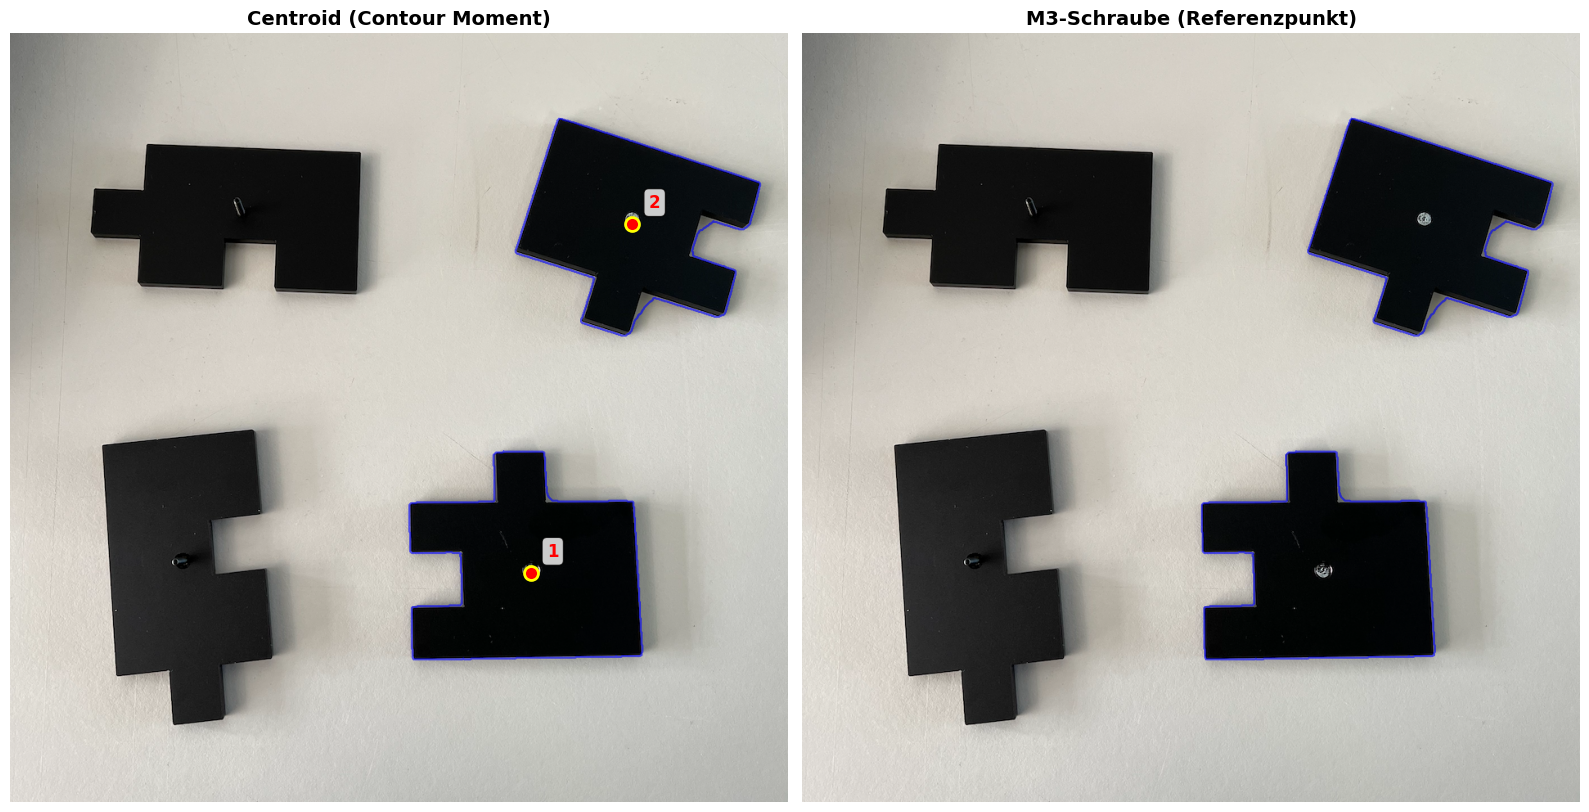

In [68]:
# Visualisierung: Vergleich Centroid vs. M3-Schraube
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Originalbild mit Centroiden
axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Centroid (Contour Moment)', fontsize=14, weight='bold')
axes[0].axis('off')

# Centroiden einzeichnen
for i, piece_data in enumerate(pieces_data):
    # Contour einzeichnen
    contour_array = np.array([[p.x, p.y] for p in piece_data['points']], dtype=np.int32)
    axes[0].plot(contour_array[:, 0], contour_array[:, 1], 'b-', linewidth=1.5, alpha=0.6)
    
    # Centroid markieren
    centroid = piece_data['centroid']
    axes[0].plot(centroid.x, centroid.y, 'ro', markersize=10, 
                 markeredgecolor='yellow', markeredgewidth=2)
    axes[0].text(centroid.x + 20, centroid.y - 20, str(i+1),
                 fontsize=12, color='red', weight='bold', 
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Originalbild mit M3-Schrauben
axes[1].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axes[1].set_title('M3-Schraube (Referenzpunkt)', fontsize=14, weight='bold')
axes[1].axis('off')

# M3-Schrauben einzeichnen
for i, piece_data in enumerate(pieces_data):
    # Contour einzeichnen
    contour_array = np.array([[p.x, p.y] for p in piece_data['points']], dtype=np.int32)
    axes[1].plot(contour_array[:, 0], contour_array[:, 1], 'b-', linewidth=1.5, alpha=0.6)
    
    # M3-Schraube markieren (falls gefunden)
    screw_data = m3_screw_positions[i]
    if screw_data['position'] is not None:
        screw_x, screw_y = screw_data['position']
        axes[1].plot(screw_x, screw_y, 'go', markersize=12, 
                    markeredgecolor='yellow', markeredgewidth=2, label='M3-Schraube' if i == 0 else '')
        axes[1].text(screw_x + 20, screw_y - 20, str(i+1),
                    fontsize=12, color='green', weight='bold', 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()